## COVID-19 Vaccination Hesitancy Textual Analysis

## Environment Setup

In [ ]:
# Install modules
!pip install geocoder
!pip install pycountry
!pip install langdetect
!pip install googletrans==3.1.0a0
!pip install vaderSentiment
!pip install flair

     |████████████████████████████████| 98 kB 2.5 MB/s 
     |████████████████████████████████| 10.1 MB 3.6 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=5e054f99009ea479189dd4530d7a513250da4ef94d8c162f9b93a8f136732d37
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry
     |████████████████████████████████| 981 kB 4.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=7439c57939cca58fcd01e0c51cb90a53b2662c2d6624921663a8e2d56531659a
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 7.1 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |██

In [ ]:
# Import modules
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import geocoder
from geopy.geocoders import Nominatim
import pycountry
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from langdetect import detect
from googletrans import Translator
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
from textblob import TextBlob
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Improt drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Import data from google drive
df_tweets = pd.read_csv('/content/gdrive/My Drive/BA890/vaccination_all_tweets.csv')
df_process = pd.read_csv('/content/gdrive/My Drive/BA890/country_vaccinations.csv')

In [ ]:
print(f'The rows and columns of vaccine process are: {df_process.shape}')
print(f'The rows and columns of tweets dataset are: {df_tweets.shape}')

The rows and columns of vaccine process are: (51308, 15)
The rows and columns of tweets dataset are: (206967, 16)


In [ ]:
# Check the form of vaccine process dataset
df_process.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


In [ ]:
# Check the form of tweet dataset
df_tweets.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False


## Tweet Dataset

### Data Cleaning

In [ ]:
# Obtain the dataset for cleaning
df_tweets_cleaning =df_tweets.copy()

In [ ]:
# Drop duplicates
print(df_tweets_cleaning.shape)
df_tweets_cleaning = df_tweets_cleaning.drop_duplicates()
print(df_tweets_cleaning.shape)

(206967, 16)
(206967, 16)


In [ ]:
# Select columns that are useful for analysis
df_tweets_cleaning = df_tweets_cleaning[['id', 'date', 'user_verified', 'user_location', 'text']]

In [ ]:
# Print the head of the data
df_tweets_cleaning.head(3)

,id,date,user_verified,user_location,text
0,1340539111971516416,2020-12-20 06:06:44,False,"La Crescenta-Montrose, CA",Same folks said daikon paste could treat a cyt...
1,1338158543359250433,2020-12-13 16:27:13,False,"San Francisco, CA",While the world has been on the wrong side of ...
2,1337858199140118533,2020-12-12 20:33:45,False,Your Bed,#coronavirus #SputnikV #AstraZeneca #PfizerBio...


We tweak the dataset column by column. 

#### Date

In [ ]:
# Print out the date to see its format
df_tweets_cleaning.date

0         2020-12-20 06:06:44
1         2020-12-13 16:27:13
2         2020-12-12 20:33:45
3         2020-12-12 20:23:59
4         2020-12-12 20:17:19
                 ...         
206962    2021-10-07 04:00:05
206963    2021-10-07 03:39:21
206964    2021-10-07 03:30:26
206965    2021-10-07 03:30:15
206966    2021-10-07 03:00:15
Name: date, Length: 206967, dtype: object

In [ ]:
# Extract year, month, and day from original date
df_tweets_cleaning['date'] = pd.to_datetime(df_tweets_cleaning.date, format='%Y-%m-%d')
df_tweets_cleaning['date'] = df_tweets_cleaning['date'].dt.strftime('%Y-%m-%d')

In [ ]:
# Print the head of the data
df_tweets_cleaning.head(3)

,id,date,user_verified,user_location,text
0,1340539111971516416,2020-12-20,False,"La Crescenta-Montrose, CA",Same folks said daikon paste could treat a cyt...
1,1338158543359250433,2020-12-13,False,"San Francisco, CA",While the world has been on the wrong side of ...
2,1337858199140118533,2020-12-12,False,Your Bed,#coronavirus #SputnikV #AstraZeneca #PfizerBio...


#### Verified Users

In [ ]:
# Output the total numbers of values of each type of verified users
df_tweets_cleaning['user_verified'].value_counts()

False    189542
True      17425
Name: user_verified, dtype: int64

Since verified users merely accounts for less than 10 percent of the entire dataset, we decide to use both verified and unverified values for analysis.

In [ ]:
# Drop verified users column as we are not going to use it
df_tweets_cleaning = df_tweets_cleaning.drop(['user_verified'], axis = 1)

#### Manage User location

In [ ]:
# Check user location
df_tweets['user_location'].value_counts().nlargest(30)

Bengaluru, India                  17340
India                              7317
New Delhi, India                   2778
Toronto, Canada  and Worldwide     2653
Mumbai, India                      1772
United States                      1755
New Delhi                          1120
Sri Lanka                          1078
Beijing, China                      949
Mumbai                              931
Canada                              887
Toronto, Ontario                    880
London, England                     872
London                              837
Hyderabad, India                    781
Los Angeles, CA                     779
Chennai, India                      694
Beijing                             644
Malaysia                            618
California, USA                     583
Colombo, Sri Lanka                  560
USA                                 558
Pakistan                            556
United Kingdom                      551
World                               519


Value contains countries, cities, etc. We should convert all sorts of location values to country.

In [ ]:
# Transform miscellaneous locations to country

# Create a function to convert location to country
def Location_transform_Country(original_location):
  if original_location is not None:
    for country in pycountry.countries:
      if country.name in str(original_location):
        return country.name

    geolocator = Nominatim(user_agent = "geoapiExercises")
    location = geolocator.geocode(original_location,timeout=10000)
    if location is not None:
      location = location[0]

      for country in pycountry.countries:
        if country.name in location:
          return country.name

# Apply the function to dataset
df_tweets_cleaning['country'] = df_tweets_cleaning.user_location.apply(Location_transform_Country)

In [ ]:
# It takes hours to run the previous code, so we ran it separately and output the csv file.
from google.colab import files
df_tweets_cleaning.to_csv('df_tweets_clean.csv')
files.download('df_tweets_clean.csv')

In [ ]:
# Input the completed file
df_tweets_cleaning = pd.read_csv('/content/gdrive/My Drive/BA890/df_tweets_clean.csv')
df_tweets_cleaning = df_tweets_cleaning[['id', 'date', 'country', 'text']]

In [ ]:
# Check the missing value again
df_tweets_cleaning.isna().sum()

id             5
date           5
country    84607
text           5
dtype: int64

It seems some values are missing after transforming them to country, we will drop them.

In [ ]:
# Drop values without country
print(df_tweets_cleaning.shape)
df_tweets_cleaning = df_tweets_cleaning.dropna()
df_tweets_cleaning = df_tweets_cleaning[['id', 'date', 'country', 'text']]
print(df_tweets_cleaning.shape)

(206972, 4)
(122365, 4)


In [ ]:
# Check if missing values are successfully removed
df_tweets_cleaning.isna().sum()

id         0
date       0
country    0
text       0
dtype: int64

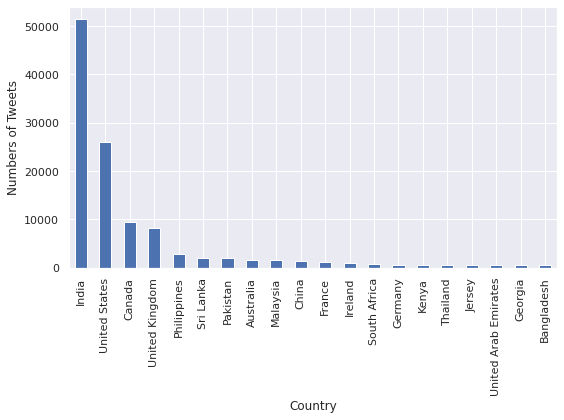

In [ ]:
# Visualize Tweet Count vs Country
plt.figure(figsize=(8,6))
df_tweets_cleaning['country'].value_counts().nlargest(20).plot(kind='bar')
plt.xticks()
plt.xlabel('Country')
plt.ylabel('Numbers of Tweets')
plt.tight_layout()
plt.savefig('Numbers of Tweets by Country.jpeg', dpi = 300)
plt.show();

In [ ]:
# Count the exact numbers of tweet for each countries and select the top 5
df_tweets_cleaning['country'].value_counts().nlargest(5)

India             51459
United States     26056
Canada             9528
United Kingdom     8121
Philippines        2765
Name: country, dtype: int64

To ensure ample numbers of samples, we merely analyze conturies with over 5000 tweets. Selected countries are India, United States, Canda, and United Kingdom.

In [ ]:
# Select countries with over 5000 tweets
print(df_tweets_cleaning.shape)
df_tweets_cleaning = df_tweets_cleaning.loc[df_tweets_cleaning['country'].isin(['India','United States', 'Canada', 'United Kingdom'])]
print(df_tweets_cleaning.shape)
print(df_process_cleaning.shape)
df_process_cleaning = df_process_cleaning.loc[df_process_cleaning['country'].isin(['India','United States', 'Canada', 'United Kingdom'])]
print(df_process_cleaning.shape)

(122365, 4)
(95164, 4)
(51308, 5)
(1182, 5)


#### Text Processing

In [ ]:
# Lowercase
# (Though we have done it in previous dataset, we will do it again here to make
# the logic of cleaning process more complete)
df_tweets_cleaning['text'] = df_tweets_cleaning['text'].str.lower()

# Remove URL
df_tweets_cleaning['text'] = df_tweets_cleaning['text'].apply(lambda x:re.sub(r"http\S+", "", x))

# Remove hashtags
df_tweets_cleaning['text'] = df_tweets_cleaning['text'].apply(lambda x:re.sub(r"#\w+", "", x))

# Remove twitter id
df_tweets_cleaning['text'] = df_tweets_cleaning['text'].apply(lambda x:re.sub(r"@[^\s]+", "", x))

# Remove line breaks
df_tweets_cleaning['text'] = df_tweets_cleaning['text'].apply(lambda x:re.sub(r"\n", " ", x))

# Remove multiple spaces
df_tweets_cleaning['text'] = df_tweets_cleaning['text'].apply(lambda x:re.sub(r"\s\s+", " ", x))

In [ ]:
df_tweets_cleaning['text'].isna().sum()

0

In [ ]:
# Detect text language
def detect_lanugage(language):
  try:
    return detect(language)
  except:
    return None

df_tweets_cleaning['language'] = df_tweets_cleaning['text'].apply(detect_lanugage)

In [ ]:
# As detecting text languages takes several minutes, we output the dataset and input again so that
# we don't have to re-run the code when restarting the environment
df_tweets_cleaning.to_csv('language detection.csv')

In [ ]:
df_tweets_cleaning = pd.read_csv('/content/gdrive/My Drive/BA890/language detection.csv')

In [ ]:
# select non-english texts and translate them to english with google translator
df_tweets_foreign = df_tweets_cleaning.loc[df_tweets_cleaning['language'] != 'en']
df_tweets_foreign = df_tweets_foreign.reset_index().drop(columns = ['index'])

def my_translator(original_text, language_type):
  translator = Translator()
  result = translator.translate(original_text)
  return result.text

# select "english only" text
df_tweets_en = df_tweets_cleaning.loc[df_tweets_cleaning['language'] == 'en']

# Combine two datasets together
print(df_tweets_en.shape)
print(df_tweets_foreign.shape)
df_tweets_cleaning = df_tweets_en.append(df_tweets_foreign)
print(df_tweets_cleaning.shape)

(88308, 12)
(6856, 12)
(95164, 12)


In [ ]:
# Remove single character
df_tweets_cleaning["text"] = df_tweets_cleaning["text"].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Replace empty strings with NaN
df_tweets_cleaning = df_tweets_cleaning.replace(r'^\s*$', np.NaN, regex=True)

In [ ]:
# Drop null values in the text column
df_tweets_cleaning = df_tweets_cleaning.dropna(subset = ['text'])

# Check null values
df_tweets_cleaning.isna().sum()

Unnamed: 0              0
id                      0
date                    0
country                 0
text                    0
Oxford/AstraZeneca      0
Johnson&Johnson         0
Moderna                 0
Pfizer/BioNTech         0
Covaxin                 0
Sputnik V               0
language              170
dtype: int64

We have prepared both tweet and vaccine process dataset and could now move on to analysis.

##### **Pre-processing for Other Sentiment Models**

In [ ]:
# Obtain the dataset for other sentimeent models
df_tweets_analysis_other = df_tweets_analysis.copy()

In [ ]:
# Further data cleaning: remove punctuation
df_tweets_analysis_other['text'] = df_tweets_analysis_other['text'].apply(lambda x:re.sub(r"[^\w\s]", "", x))

In [ ]:
# Word Tokenization, lemmetization, and remove stopwords
def word_process(twitter_text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(twitter_text)
  lemmatizer = WordNetLemmatizer()
  filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
  sentence =' '.join(filtered_sentence)
  return sentence

df_tweets_analysis_other['text'] = df_tweets_analysis_other['text'].apply(word_process)

In [ ]:
# Check the text values
df_tweets_analysis_other['text']

0       world wrong side history year hopefully bigges...
1       fact immutable senator even youre ethically st...
2       anyone useful adviceguidance whether covid vac...
3       agency also released new information health ca...
4       trump announces rollout le 24 hour first ameri...
                              ...                        
6851                                                  mid
6852                                             2nd dose
6853                                            important
6854    pincode 560010 covaxin dose 2 50 slot age 18 4...
6855        sputnik light 70 effective delta variant rdif
Name: text, Length: 94796, dtype: object

### Data Analysis

In [ ]:
# Get the dataset for analysis
df_tweets_analysis = df_tweets_cleaning.copy()

In [ ]:
# Output dataset that is ready for analysis
df_tweets_analysis.to_csv('tweet_analysis.csv')

In [ ]:
# Read the dataset back
df_tweets_analysis = pd.read_csv('/content/gdrive/My Drive/BA890/tweet_analysis.csv')

#### Sentiment Analysis

##### **Flair Text Model**

In [ ]:
# Define flair model function
classifier = TextClassifier.load('en-sentiment')

def flair_model(input_text):
  sentence = Sentence(input_text)
  classifier.predict(sentence, mini_batch_size=32)
  text_string = str(sentence.labels[0])
  absolute_score = float(re.search(r'\d+\.\d+', text_string).group())
  if 'POSITIVE' in text_string:
    return absolute_score
  return -(absolute_score)

In [ ]:
# Apply the model to the entire dataset
df_tweets_analysis['flair_sent_score'] = df_tweets_analysis.text.apply(flair_model)

In [ ]:
# As it takes several hours to run the code, we output the data and save it for next time
# We export as html since it is easy for csv file to collapse
df_tweets_analysis.to_html('flair_sent_score.html')

In [ ]:
# Input the data again
df_tweets_analysis = pd.read_html('/content/gdrive/My Drive/BA890/flair_sent_score.html')
df_tweets_analysis = df_tweets_analysis[0]
df_tweets_analysis = df_tweets_analysis.loc[:,'id':]

In [ ]:
# Print the head of the data
df_tweets_analysis.head(3)

,id,date,country,text,Oxford/AstraZeneca,Johnson&Johnson,Moderna,Pfizer/BioNTech,Covaxin,Sputnik V,language,flair_sent_score
0,1.338159e+18,2020-12-13,United States,while the world has been on the wrong side of ...,0,0,0,0,0,0,en,0.9093
1,1.337856e+18,2020-12-12,Canada,"facts are immutable, senator, even when you're...",0,0,0,0,0,0,en,0.9935
2,1.337853e+18,2020-12-12,United Kingdom,does anyone have any useful advice/guidance fo...,0,0,0,0,0,0,en,-0.9969


In [ ]:
# Obtain statistics of flair sentiment score
df_tweets_analysis.flair_sent_score.describe()

count    94796.000000
mean        -0.076141
std          0.905610
min         -1.000000
25%         -0.984500
50%         -0.612850
75%          0.956100
max          1.000000
Name: flair_sent_score, dtype: float64

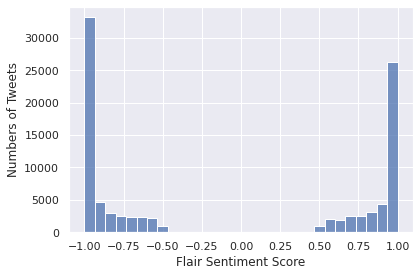

In [ ]:
# Draw histogram of flair sentiment
df_flair = df_tweets_analysis.copy()
df_flair = df_flair.rename(columns = {'flair_sent_score': 'Flair Sentiment Score'})
sns.reset_orig()
sns.set(rc={'figure.figsize':(6,4)})
sns.histplot(data = df_flair, x = 'Flair Sentiment Score', bins = 30)
plt.ylabel('Numbers of Tweets')
plt.tight_layout()
plt.savefig('Histogram of flair sent score.jpeg', dpi = 300);

##### **Textblob Sentiment Analysis**

In [ ]:
df_tweets_analysis = df_tweets_analysis_other.copy()

In [ ]:
# Get textblob sentiment score
def textblob_sentiment_score(text_input):
  return TextBlob(text_input).sentiment.polarity

df_tweets_analysis['textblob_sent_score'] = df_tweets_analysis.text.apply(textblob_sentiment_score)

In [ ]:
# Obtain statistics of textblob sentiment score
df_tweets_analysis.textblob_sent_score.describe()

count    94796.000000
mean         0.101988
std          0.230877
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.208333
max          1.000000
Name: textblob_sent_score, dtype: float64

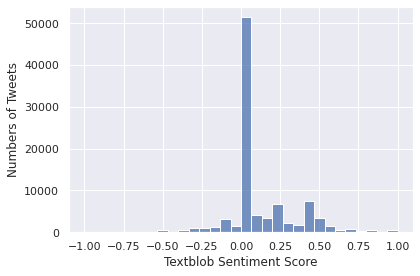

In [ ]:
# Draw histogram of textblob sentiment
df_textblob = df_tweets_analysis.copy()
df_textblob = df_textblob.rename(columns = {'textblob_sent_score': 'Textblob Sentiment Score'})
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("darkgrid")
sns.histplot(data = df_textblob, x = 'Textblob Sentiment Score', bins = 30)
plt.ylabel('Numbers of Tweets')
plt.tight_layout()
plt.savefig('Histogram of textblob sent score.jpeg', dpi = 300);

##### **Vader Sentiment Analysis**

In [ ]:
# Get the dataset for analysis
df_tweets_analysis = df_tweets_analysis_other.copy()

In [ ]:
# Sentiment Analysis, VADER SIA package 

# Define the function
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object and find out the score of the text
  sia = SentimentIntensityAnalyzer()
  sentiment_dict = sia.polarity_scores(word_tokenize(sentence))
  return sentiment_dict['compound']

# Apply the function to dataset
df_tweets_analysis['vader_sent_score'] = df_tweets_analysis.text.apply(sentiment_scores)

In [ ]:
# Since it takes several minutes to run the code we will output the dataset and input again
df_tweets_analysis.to_csv('Vader_sent.csv')

In [ ]:
# Input the data
df_tweets_analysis = pd.read_csv('/content/gdrive/My Drive/BA890/Vader_sent.csv')
df_tweets_analysis = df_tweets_analysis.loc[:, 'id':]

In [ ]:
# Obtain statistics of vader sentiment score
df_tweets_analysis.vader_sent_score.describe()

count    94796.000000
mean         0.000947
std          0.024544
min         -0.624900
25%          0.000000
50%          0.000000
75%          0.000000
max          0.636900
Name: vader_sent_score, dtype: float64

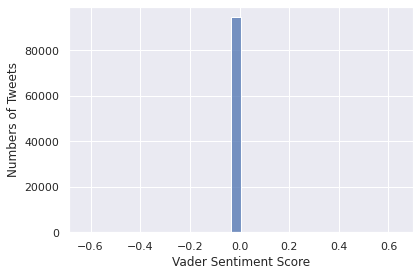

In [ ]:
# Draw histogram of vader sentiment
df_vader = df_tweets_analysis.copy()
df_vader = df_vader.rename(columns = {'vader_sent_score': 'Vader Sentiment Score'})
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("darkgrid")
sns.histplot(data = df_vader, x = 'Vader Sentiment Score', bins = 30)
plt.ylabel('Numbers of Tweets')
plt.tight_layout()
plt.savefig('Histogram of vader sent score.jpeg', dpi = 300);

#### Most Common Key Words in Tweets

##### **India**

In [ ]:
# Select the data from the India
df_tweets_ind = df_tweets_analysis.loc[df_tweets_analysis['country'] == 'India']
df_tweets_ind = df_tweets_ind.dropna(subset = ['text'])

In [ ]:
# Define a function to get 'most common words' visualization
def most_common_words(text, ngram):
  # Fit and transform the text
  text = text.to_list()
  count = CountVectorizer(ngram_range = ngram)
  vect = count.fit_transform(text)

  # Get the dataframe of count vectorizer
  df_vector = pd.DataFrame()
  vocab = count.get_feature_names()
  vocab_count = np.sum(vect, axis=0).tolist()[0]
  vaccine_most_common = pd.DataFrame(list(zip(vocab,vocab_count))) 
  vaccine_most_common.columns =['Common Words', 'Count']
  vaccine_most_common = vaccine_most_common.sort_values(by = 'Count', ascending= False)
  return vaccine_most_common

Unigram

In [ ]:
# Apply the function to uni-gram analysis
common_tweets_ind = most_common_words(df_tweets_ind['text'], (1,1))

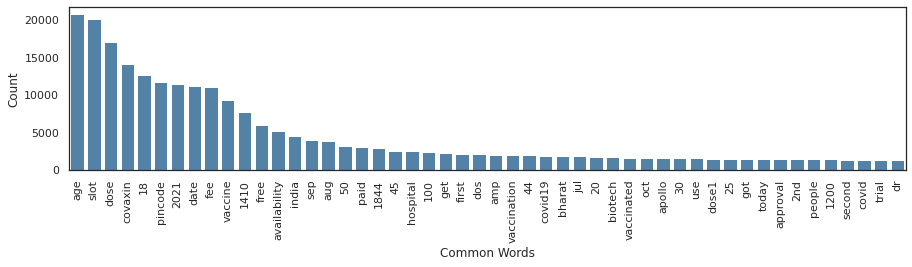

In [ ]:
# Tabulate the most common words
ct_ind_uni_top_30 = common_tweets_ind_uni.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ind_unigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ind_uni_top_30, color ='steelblue')
ind_unigram_vis.set_xticklabels(ind_unigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ind unigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common uni-gram
ind_uni_gram = common_tweets_ind_uni.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ind_uni_gram.txt", "w") as output:
    output.write(str(ind_uni_gram))

In [ ]:
# Transform the list to array and output it
np.array(ind_uni_gram)

array(['age', 'slot', 'dose', 'covaxin', '18', 'pincode', '2021', 'date',
       'fee', 'vaccine', '1410', 'free', 'availability', 'india', 'sep',
       'aug', '50', 'paid', '1844', '45', 'hospital', '100', 'get',
       'first', 'dos', 'amp', 'vaccination', '44', 'covid19', 'bharat',
       'jul', '20', 'biotech', 'vaccinated', 'oct', 'apollo', '30', 'use',
       'dose1', '25', 'got', 'today', 'approval', '2nd', 'people', '1200',
       'second', 'covid', 'trial', 'dr'], dtype='<U12')

Bigram

In [ ]:
# Apply the function to bi-gram analysis
common_tweets_ind_bi = most_common_words(df_tweets_ind['text'], (2,2))

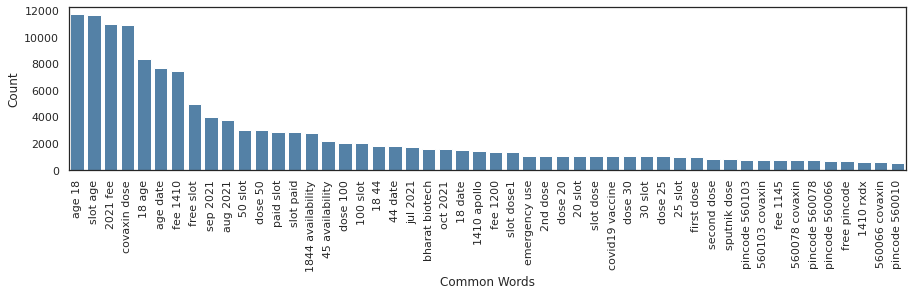

In [ ]:
# Tabulate the most common words
ct_ind_bi_top_30 = common_tweets_ind_bi.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ind_bigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ind_bi_top_30, color ='steelblue')
ind_bigram_vis.set_xticklabels(ind_bigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ind bigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common bi-gram
ind_bi_gram = common_tweets_ind_bi.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ind_bi_gram.txt", "w") as output:
    output.write(str(ind_bi_gram))

In [ ]:
# Transform the list to array and output it
np.array(ind_bi_gram)

array(['age 18', 'slot age', '2021 fee', 'covaxin dose', '18 age',
       'age date', 'fee 1410', 'free slot', 'sep 2021', 'aug 2021',
       '50 slot', 'dose 50', 'paid slot', 'slot paid',
       '1844 availability', '45 availability', 'dose 100', '100 slot',
       '18 44', '44 date', 'jul 2021', 'bharat biotech', 'oct 2021',
       '18 date', '1410 apollo', 'fee 1200', 'slot dose1',
       'emergency use', '2nd dose', 'dose 20', '20 slot', 'slot dose',
       'covid19 vaccine', 'dose 30', '30 slot', 'dose 25', '25 slot',
       'first dose', 'second dose', 'sputnik dose', 'pincode 560103',
       '560103 covaxin', 'fee 1145', '560078 covaxin', 'pincode 560078',
       'pincode 560066', 'free pincode', '1410 rxdx', '560066 covaxin',
       'pincode 560010'], dtype='<U17')

Trigram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_ind_tri = most_common_words(df_tweets_ind['text'], (3,3))

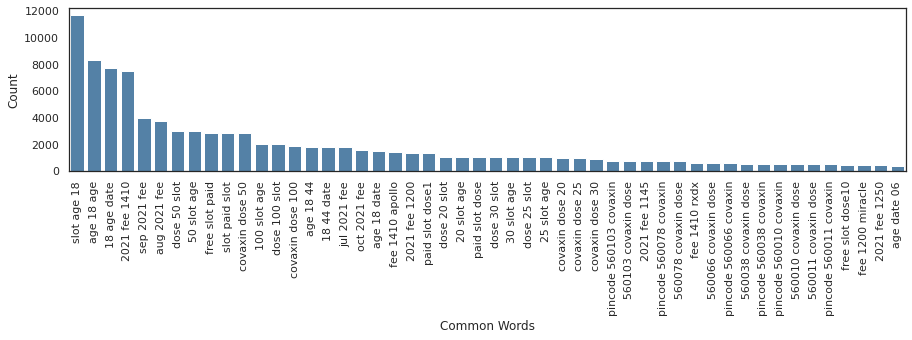

In [ ]:
# Tabulate the most common words
ct_ind_tri_top_30 = common_tweets_ind_tri.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ind_trigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ind_tri_top_30, color ='steelblue')
ind_trigram_vis.set_xticklabels(ind_trigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ind trigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common tri-gram
ind_tri_gram = common_tweets_ind_tri.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ind_tri_gram.txt", "w") as output:
    output.write(str(ind_tri_gram))

In [ ]:
# Transform the list to array and output it
np.array(ind_tri_gram)

array(['slot age 18', 'age 18 age', '18 age date', '2021 fee 1410',
       'sep 2021 fee', 'aug 2021 fee', 'dose 50 slot', '50 slot age',
       'free slot paid', 'slot paid slot', 'covaxin dose 50',
       '100 slot age', 'dose 100 slot', 'covaxin dose 100', 'age 18 44',
       '18 44 date', 'jul 2021 fee', 'oct 2021 fee', 'age 18 date',
       'fee 1410 apollo', '2021 fee 1200', 'paid slot dose1',
       'dose 20 slot', '20 slot age', 'paid slot dose', 'dose 30 slot',
       '30 slot age', 'dose 25 slot', '25 slot age', 'covaxin dose 20',
       'covaxin dose 25', 'covaxin dose 30', 'pincode 560103 covaxin',
       '560103 covaxin dose', '2021 fee 1145', 'pincode 560078 covaxin',
       '560078 covaxin dose', 'fee 1410 rxdx', '560066 covaxin dose',
       'pincode 560066 covaxin', '560038 covaxin dose',
       'pincode 560038 covaxin', 'pincode 560010 covaxin',
       '560010 covaxin dose', '560011 covaxin dose',
       'pincode 560011 covaxin', 'free slot dose10', 'fee 1200 miracle'

4 gram

In [ ]:
# Apply the function to 4-gram analysis
common_tweets_ind_4 = most_common_words(df_tweets_ind['text'], (4,4))

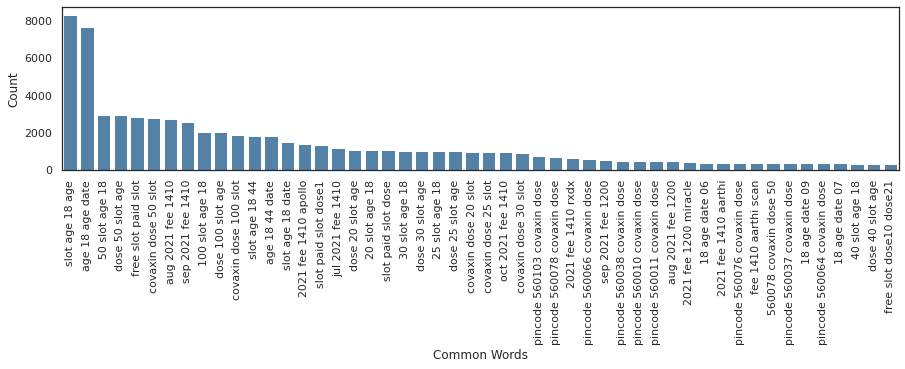

In [ ]:
# Tabulate the most common words
ct_ind_4_top_30 = common_tweets_ind_4.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ind_4gram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ind_4_top_30, color ='steelblue')
ind_4gram_vis.set_xticklabels(ind_4gram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ind 4gram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common 4-gram
ind_4_gram = common_tweets_ind_4.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ind_4_gram.txt", "w") as output:
    output.write(str(ind_4_gram))

In [ ]:
# Transform the list to array and output it
np.array(ind_4_gram)

array(['slot age 18 age', 'age 18 age date', '50 slot age 18',
       'dose 50 slot age', 'free slot paid slot', 'covaxin dose 50 slot',
       'aug 2021 fee 1410', 'sep 2021 fee 1410', '100 slot age 18',
       'dose 100 slot age', 'covaxin dose 100 slot', 'slot age 18 44',
       'age 18 44 date', 'slot age 18 date', '2021 fee 1410 apollo',
       'slot paid slot dose1', 'jul 2021 fee 1410', 'dose 20 slot age',
       '20 slot age 18', 'slot paid slot dose', '30 slot age 18',
       'dose 30 slot age', '25 slot age 18', 'dose 25 slot age',
       'covaxin dose 20 slot', 'covaxin dose 25 slot',
       'oct 2021 fee 1410', 'covaxin dose 30 slot',
       'pincode 560103 covaxin dose', 'pincode 560078 covaxin dose',
       '2021 fee 1410 rxdx', 'pincode 560066 covaxin dose',
       'sep 2021 fee 1200', 'pincode 560038 covaxin dose',
       'pincode 560010 covaxin dose', 'pincode 560011 covaxin dose',
       'aug 2021 fee 1200', '2021 fee 1200 miracle', '18 age date 06',
       '2021 fee 

##### **United States**

In [ ]:
# Select the data from the US
df_tweets_usa = df_tweets_analysis.loc[df_tweets_analysis['country'] == 'United States']
df_tweets_usa = df_tweets_usa.dropna(subset = ['text'])

Unigram

In [ ]:
# Apply the function to uni-gram analysis
common_tweets_usa = most_common_words(df_tweets_usa['text'], (1,1))

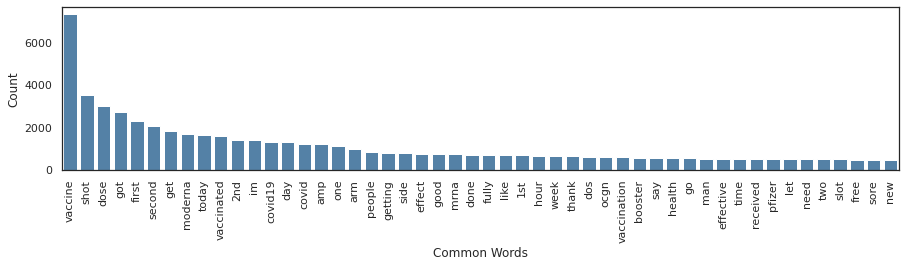

In [ ]:
# Tabulate the most common words
ct_usa_uni_top_30 = common_tweets_usa_uni.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
usa_unigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_usa_uni_top_30, color ='steelblue')
usa_unigram_vis.set_xticklabels(usa_unigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('usa unigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common uni-gram
usa_uni_gram = common_tweets_usa_uni.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("usa_uni_gram.txt", "w") as output:
    output.write(str(usa_uni_gram))

In [ ]:
# Transform the list to array and output it
np.array(usa_uni_gram)

array(['vaccine', 'shot', 'dose', 'got', 'first', 'second', 'get',
       'moderna', 'today', 'vaccinated', '2nd', 'im', 'covid19', 'day',
       'covid', 'amp', 'one', 'arm', 'people', 'getting', 'side',
       'effect', 'good', 'mrna', 'done', 'fully', 'like', '1st', 'hour',
       'week', 'thank', 'dos', 'ocgn', 'vaccination', 'booster', 'say',
       'health', 'go', 'man', 'effective', 'time', 'received', 'pfizer',
       'let', 'need', 'two', 'slot', 'free', 'sore', 'new'], dtype='<U11')

Bigram

In [ ]:
# Apply the function to bi-gram analysis
common_tweets_usa_bi = most_common_words(df_tweets_usa['text'], (2,2))

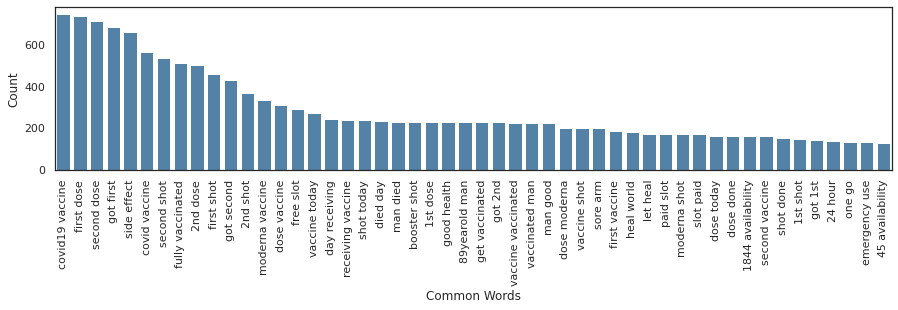

In [ ]:
# Tabulate the most common words
ct_usa_bi_top_30 = common_tweets_usa_bi.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
usa_bigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_usa_bi_top_30, color ='steelblue')
usa_bigram_vis.set_xticklabels(usa_bigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('usa bigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common bi-gram
usa_bi_gram = common_tweets_usa_bi.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("usa_bi_gram.txt", "w") as output:
    output.write(str(usa_bi_gram))

In [ ]:
# Transform the list to array and output it
np.array(usa_bi_gram)

array(['covid19 vaccine', 'first dose', 'second dose', 'got first',
       'side effect', 'covid vaccine', 'second shot', 'fully vaccinated',
       '2nd dose', 'first shot', 'got second', '2nd shot',
       'moderna vaccine', 'dose vaccine', 'free slot', 'vaccine today',
       'day receiving', 'receiving vaccine', 'shot today', 'died day',
       'man died', 'booster shot', '1st dose', 'good health',
       '89yearold man', 'get vaccinated', 'got 2nd', 'vaccine vaccinated',
       'vaccinated man', 'man good', 'dose moderna', 'vaccine shot',
       'sore arm', 'first vaccine', 'heal world', 'let heal', 'paid slot',
       'moderna shot', 'slot paid', 'dose today', 'dose done',
       '1844 availability', 'second vaccine', 'shot done', '1st shot',
       'got 1st', '24 hour', 'one go', 'emergency use', '45 availability'],
      dtype='<U18')

Trigram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_usa_tri = most_common_words(df_tweets_usa['text'], (3,3))

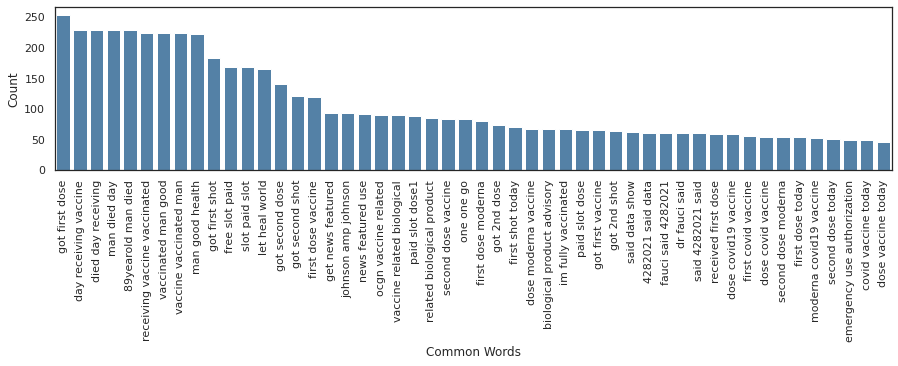

In [ ]:
# Tabulate the most common words
ct_usa_tri_top_30 = common_tweets_usa_tri.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
usa_trigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_usa_tri_top_30, color ='steelblue')
usa_trigram_vis.set_xticklabels(usa_trigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('usa trigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common tri-gram
usa_tri_gram = common_tweets_usa_tri.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("usa_tri_gram.txt", "w") as output:
    output.write(str(usa_tri_gram))

In [ ]:
# Transform the list to array and output it
np.array(usa_tri_gram)

array(['got first dose', 'day receiving vaccine', 'died day receiving',
       'man died day', '89yearold man died',
       'receiving vaccine vaccinated', 'vaccinated man good',
       'vaccine vaccinated man', 'man good health', 'got first shot',
       'free slot paid', 'slot paid slot', 'let heal world',
       'got second dose', 'got second shot', 'first dose vaccine',
       'get news featured', 'johnson amp johnson', 'news featured use',
       'ocgn vaccine related', 'vaccine related biological',
       'paid slot dose1', 'related biological product',
       'second dose vaccine', 'one one go', 'first dose moderna',
       'got 2nd dose', 'first shot today', 'dose moderna vaccine',
       'biological product advisory', 'im fully vaccinated',
       'paid slot dose', 'got first vaccine', 'got 2nd shot',
       'said data show', '4282021 said data', 'fauci said 4282021',
       'dr fauci said', 'said 4282021 said', 'received first dose',
       'dose covid19 vaccine', 'first covi

4-gram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_usa_4 = most_common_words(df_tweets_usa['text'], (4,4))

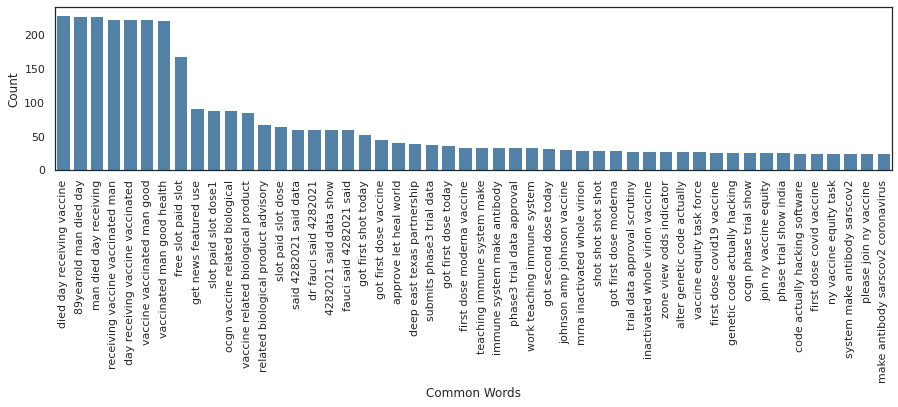

In [ ]:
# Tabulate the most common words
ct_usa_4_top_30 = common_tweets_usa_4.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
usa_4gram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_usa_4_top_30, color ='steelblue')
usa_4gram_vis.set_xticklabels(usa_4gram_vis.get_xticklabels(), rotation = 90);
plt.savefig('usa 4gram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common 4-gram
usa_4_gram = common_tweets_usa_4.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("usa_4_gram.txt", "w") as output:
    output.write(str(usa_4_gram))

In [ ]:
# Transform the list to array and output it
np.array(usa_4_gram)

array(['died day receiving vaccine', '89yearold man died day',
       'man died day receiving', 'receiving vaccine vaccinated man',
       'day receiving vaccine vaccinated', 'vaccine vaccinated man good',
       'vaccinated man good health', 'free slot paid slot',
       'get news featured use', 'slot paid slot dose1',
       'ocgn vaccine related biological',
       'vaccine related biological product',
       'related biological product advisory', 'slot paid slot dose',
       'said 4282021 said data', 'dr fauci said 4282021',
       '4282021 said data show', 'fauci said 4282021 said',
       'got first shot today', 'got first dose vaccine',
       'approve let heal world', 'deep east texas partnership',
       'submits phase3 trial data', 'got first dose today',
       'first dose moderna vaccine', 'teaching immune system make',
       'immune system make antibody', 'phase3 trial data approval',
       'work teaching immune system', 'got second dose today',
       'johnson amp john

##### **Canada**

In [ ]:
# Select the data from the Canada
df_tweets_ca = df_tweets_analysis.loc[df_tweets_analysis['country'] == 'Canada']
df_tweets_ca = df_tweets_ca.dropna(subset = ['text'])

Unigram

In [ ]:
# Apply the function to uni-gram analysis
common_tweets_ca_uni = most_common_words(df_tweets_ca['text'], (1,1))

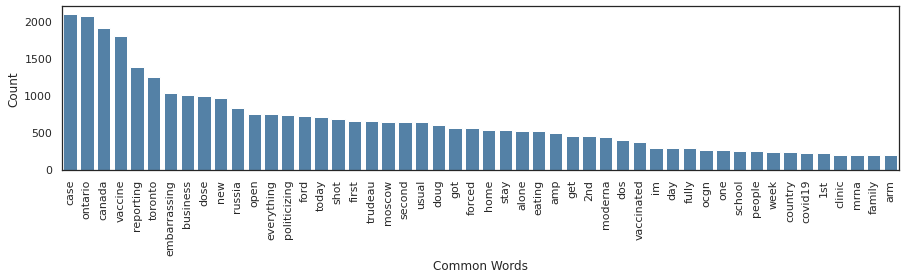

In [ ]:
# Tabulate the most common words
ct_ca_uni_top_30 = common_tweets_ca_uni.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ca_unigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ca_uni_top_30, color ='steelblue')
ca_unigram_vis.set_xticklabels(ca_unigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ca unigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common uni-gram
ca_uni_gram = common_tweets_ca_uni.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ca_uni_gram.txt", "w") as output:
    output.write(str(ca_uni_gram))

In [ ]:
# Transform the list to array and output it
np.array(ca_uni_gram)

array(['case', 'ontario', 'canada', 'vaccine', 'reporting', 'toronto',
       'embarrassing', 'business', 'dose', 'new', 'russia', 'open',
       'everything', 'politicizing', 'ford', 'today', 'shot', 'first',
       'trudeau', 'moscow', 'second', 'usual', 'doug', 'got', 'forced',
       'home', 'stay', 'alone', 'eating', 'amp', 'get', '2nd', 'moderna',
       'dos', 'vaccinated', 'im', 'day', 'fully', 'ocgn', 'one', 'school',
       'people', 'week', 'country', 'covid19', '1st', 'clinic', 'mrna',
       'family', 'arm'], dtype='<U12')

Bigram

In [ ]:
# Apply the function to bi-gram analysis
common_tweets_ca_bi = most_common_words(df_tweets_ca['text'], (2,2))

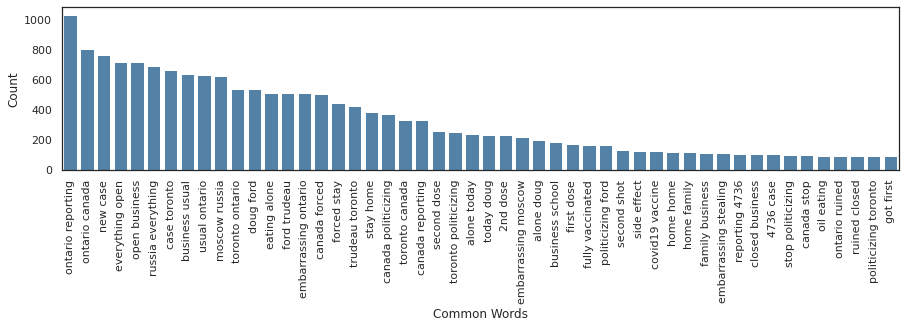

In [ ]:
# Tabulate the most common words
ct_ca_bi_top_30 = common_tweets_ca_bi.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ca_bigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ca_bi_top_30, color ='steelblue')
ca_bigram_vis.set_xticklabels(ca_bigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ca bigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common bi-gram
ca_bi_gram = common_tweets_ca_bi.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ca_bi_gram.txt", "w") as output:
    output.write(str(ca_bi_gram))

In [ ]:
# Transform the list to array and output it
np.array(ca_bi_gram)

array(['ontario reporting', 'ontario canada', 'new case',
       'everything open', 'open business', 'russia everything',
       'case toronto', 'business usual', 'usual ontario', 'moscow russia',
       'toronto ontario', 'doug ford', 'eating alone', 'ford trudeau',
       'embarrassing ontario', 'canada forced', 'forced stay',
       'trudeau toronto', 'stay home', 'canada politicizing',
       'toronto canada', 'canada reporting', 'second dose',
       'toronto politicizing', 'alone today', 'today doug', '2nd dose',
       'embarrassing moscow', 'alone doug', 'business school',
       'first dose', 'fully vaccinated', 'politicizing ford',
       'second shot', 'side effect', 'covid19 vaccine', 'home home',
       'home family', 'family business', 'embarrassing stealing',
       'reporting 4736', 'closed business', '4736 case',
       'stop politicizing', 'canada stop', 'oil eating', 'ontario ruined',
       'ruined closed', 'politicizing toronto', 'got first'], dtype='<U21')

Trigram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_ca_tri = most_common_words(df_tweets_ca['text'], (3,3))

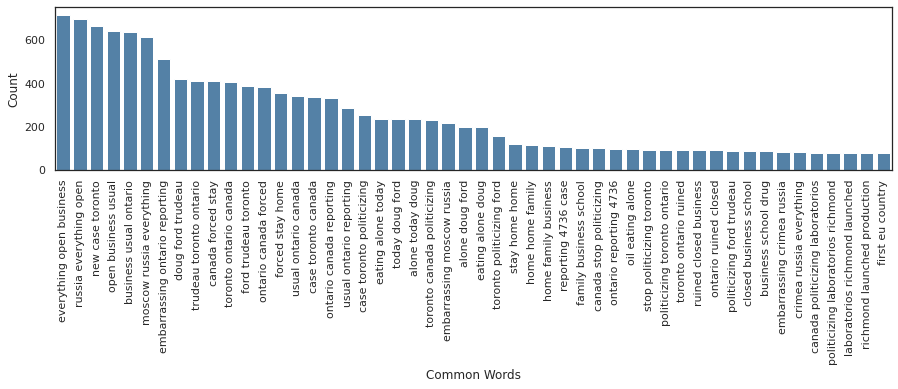

In [ ]:
# Tabulate the most common words
ct_ca_tri_top_30 = common_tweets_ca_tri.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ca_trigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ca_tri_top_30, color ='steelblue')
ca_trigram_vis.set_xticklabels(ca_trigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ca trigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common tri-gram
ca_tri_gram = common_tweets_ca_tri.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ca_tri_gram.txt", "w") as output:
    output.write(str(ca_tri_gram))

In [ ]:
# Transform the list to array and output it
np.array(ca_tri_gram)

array(['everything open business', 'russia everything open',
       'new case toronto', 'open business usual',
       'business usual ontario', 'moscow russia everything',
       'embarrassing ontario reporting', 'doug ford trudeau',
       'trudeau toronto ontario', 'canada forced stay',
       'toronto ontario canada', 'ford trudeau toronto',
       'ontario canada forced', 'forced stay home',
       'usual ontario canada', 'case toronto canada',
       'ontario canada reporting', 'usual ontario reporting',
       'case toronto politicizing', 'eating alone today',
       'today doug ford', 'alone today doug',
       'toronto canada politicizing', 'embarrassing moscow russia',
       'alone doug ford', 'eating alone doug',
       'toronto politicizing ford', 'stay home home', 'home home family',
       'home family business', 'reporting 4736 case',
       'family business school', 'canada stop politicizing',
       'ontario reporting 4736', 'oil eating alone',
       'stop politicizin

4-gram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_ca_4 = most_common_words(df_tweets_ca['text'], (4,4))

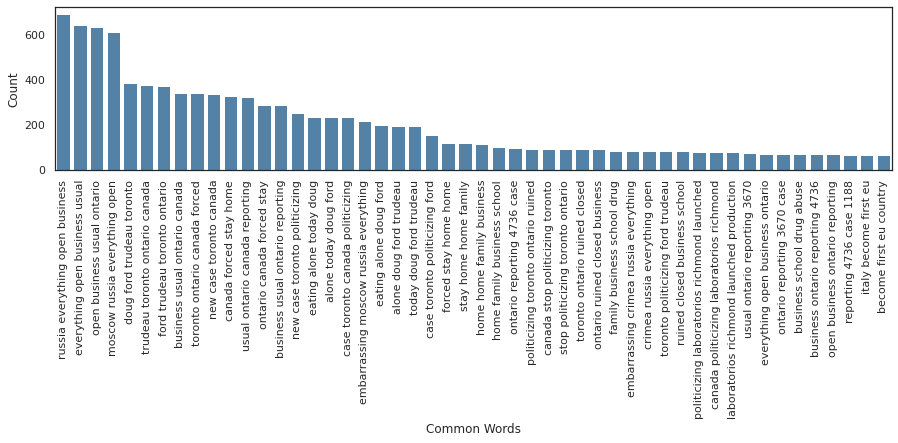

In [ ]:
# Tabulate the most common words
ct_ca_4_top_30 = common_tweets_ca_4.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
ca_4gram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_ca_4_top_30, color ='steelblue')
ca_4gram_vis.set_xticklabels(ca_4gram_vis.get_xticklabels(), rotation = 90);
plt.savefig('ca 4gram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common 4-gram
ca_4_gram = common_tweets_ca_4.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("ca_4_gram.txt", "w") as output:
    output.write(str(ca_4_gram))

In [ ]:
# Transform the list to array and output it
np.array(ca_4_gram)

array(['russia everything open business',
       'everything open business usual', 'open business usual ontario',
       'moscow russia everything open', 'doug ford trudeau toronto',
       'trudeau toronto ontario canada', 'ford trudeau toronto ontario',
       'business usual ontario canada', 'toronto ontario canada forced',
       'new case toronto canada', 'canada forced stay home',
       'usual ontario canada reporting', 'ontario canada forced stay',
       'business usual ontario reporting',
       'new case toronto politicizing', 'eating alone today doug',
       'alone today doug ford', 'case toronto canada politicizing',
       'embarrassing moscow russia everything', 'eating alone doug ford',
       'alone doug ford trudeau', 'today doug ford trudeau',
       'case toronto politicizing ford', 'forced stay home home',
       'stay home home family', 'home home family business',
       'home family business school', 'ontario reporting 4736 case',
       'politicizing toronto o

##### **United Kingdom**

In [ ]:
# Select the data from United Kingdom
df_tweets_uk = df_tweets_analysis.loc[df_tweets_analysis['country'] == 'United Kingdom']
df_tweets_uk = df_tweets_uk.dropna(subset = ['text'])

In [ ]:
# Apply the function to uni-gram analysis
common_tweets_uk_uni = most_common_words(df_tweets_uk['text'], (1,1))

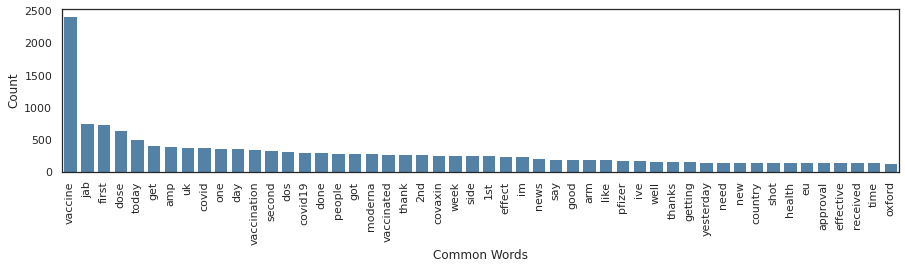

In [ ]:
# Tabulate the most common words
ct_uk_uni_top_30 = common_tweets_uk_uni.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
uk_unigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_uk_uni_top_30, color ='steelblue')
uk_unigram_vis.set_xticklabels(uk_unigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('uk unigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common uni-gram
uk_uni_gram = common_tweets_uk_uni.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("uk_uni_gram.txt", "w") as output:
    output.write(str(uk_uni_gram))

In [ ]:
# Transform the list to array and output it
np.array(uk_uni_gram)

array(['vaccine', 'jab', 'first', 'dose', 'today', 'get', 'amp', 'uk',
       'covid', 'one', 'day', 'vaccination', 'second', 'dos', 'covid19',
       'done', 'people', 'got', 'moderna', 'vaccinated', 'thank', '2nd',
       'covaxin', 'week', 'side', '1st', 'effect', 'im', 'news', 'say',
       'good', 'arm', 'like', 'pfizer', 'ive', 'well', 'thanks',
       'getting', 'yesterday', 'need', 'new', 'country', 'shot', 'health',
       'eu', 'approval', 'effective', 'received', 'time', 'oxford'],
      dtype='<U11')

Bigram

In [ ]:
# Apply the function to bi-gram analysis
common_tweets_uk_bi = most_common_words(df_tweets_uk['text'], (2,2))

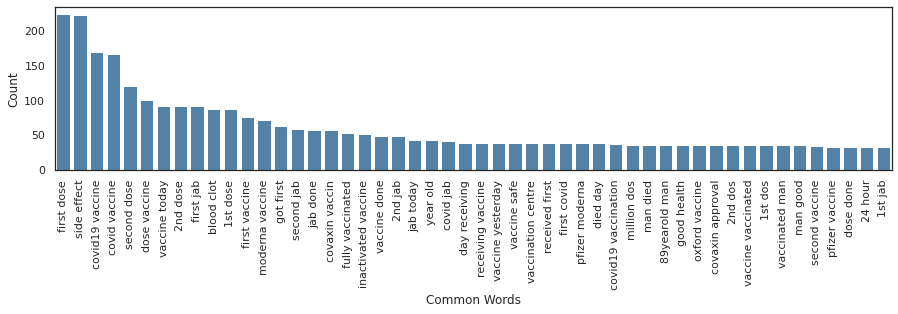

In [ ]:
# Tabulate the most common words
ct_uk_bi_top_30 = common_tweets_uk_bi.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
uk_bigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_uk_bi_top_30, color ='steelblue')
uk_bigram_vis.set_xticklabels(uk_bigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('uk bigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common bi-gram
uk_bi_gram = common_tweets_uk_bi.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("uk_bi_gram.txt", "w") as output:
    output.write(str(uk_bi_gram))

In [ ]:
# Transform the list to array and output it
np.array(uk_bi_gram)

array(['first dose', 'side effect', 'covid19 vaccine', 'covid vaccine',
       'second dose', 'dose vaccine', 'vaccine today', '2nd dose',
       'first jab', 'blood clot', '1st dose', 'first vaccine',
       'moderna vaccine', 'got first', 'second jab', 'jab done',
       'covaxin vaccin', 'fully vaccinated', 'inactivated vaccine',
       'vaccine done', '2nd jab', 'jab today', 'year old', 'covid jab',
       'day receiving', 'receiving vaccine', 'vaccine yesterday',
       'vaccine safe', 'vaccination centre', 'received first',
       'first covid', 'pfizer moderna', 'died day', 'covid19 vaccination',
       'million dos', 'man died', '89yearold man', 'good health',
       'oxford vaccine', 'covaxin approval', '2nd dos',
       'vaccine vaccinated', '1st dos', 'vaccinated man', 'man good',
       'second vaccine', 'pfizer vaccine', 'dose done', '24 hour',
       '1st jab'], dtype='<U19')

Trigram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_uk_tri = most_common_words(df_tweets_uk['text'], (3,3))

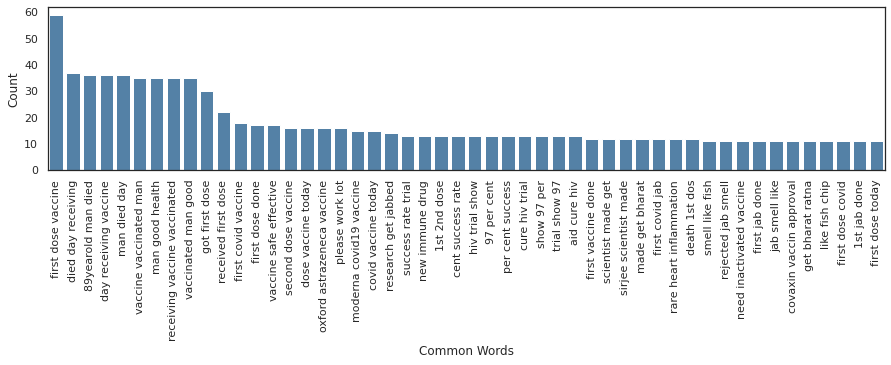

In [ ]:
# Tabulate the most common words
ct_uk_tri_top_30 = common_tweets_uk_tri.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
uk_trigram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_uk_tri_top_30, color ='steelblue')
uk_trigram_vis.set_xticklabels(uk_trigram_vis.get_xticklabels(), rotation = 90);
plt.savefig('uk trigram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common tri-gram
uk_tri_gram = common_tweets_uk_tri.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("uk_tri_gram.txt", "w") as output:
    output.write(str(uk_tri_gram))

In [ ]:
# Transform the list to array and output it
np.array(uk_tri_gram)

array(['first dose vaccine', 'died day receiving', '89yearold man died',
       'day receiving vaccine', 'man died day', 'vaccine vaccinated man',
       'man good health', 'receiving vaccine vaccinated',
       'vaccinated man good', 'got first dose', 'received first dose',
       'first covid vaccine', 'first dose done', 'vaccine safe effective',
       'second dose vaccine', 'dose vaccine today',
       'oxford astrazeneca vaccine', 'please work lot',
       'moderna covid19 vaccine', 'covid vaccine today',
       'research get jabbed', 'success rate trial', 'new immune drug',
       '1st 2nd dose', 'cent success rate', 'hiv trial show',
       '97 per cent', 'per cent success', 'cure hiv trial', 'show 97 per',
       'trial show 97', 'aid cure hiv', 'first vaccine done',
       'scientist made get', 'sirjee scientist made', 'made get bharat',
       'first covid jab', 'rare heart inflammation', 'death 1st dos',
       'smell like fish', 'rejected jab smell',
       'need inactivate

4-gram

In [ ]:
# Apply the function to tri-gram analysis
common_tweets_uk_4 = most_common_words(df_tweets_uk['text'], (4,4))

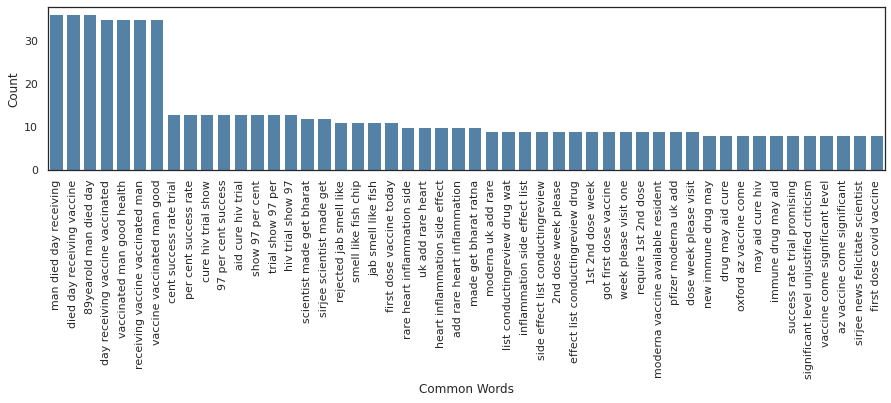

In [ ]:
# Tabulate the most common words
ct_uk_4_top_30 = common_tweets_uk_4.head(50)
sns.set(rc={"figure.figsize":(15, 3)})
sns.set_style('white')
uk_4gram_vis = sns.barplot(x = 'Common Words', y= 'Count', data = ct_uk_4_top_30, color ='steelblue')
uk_4gram_vis.set_xticklabels(uk_4gram_vis.get_xticklabels(), rotation = 90);
plt.savefig('uk 4gram.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show();

In [ ]:
# Create a list with top 50 most common 4-gram
uk_4_gram = common_tweets_uk_4.head(50)['Common Words'].to_list()

# Save the list as txt file
with open("uk_4_gram.txt", "w") as output:
    output.write(str(uk_4_gram))

In [ ]:
# Transform the list to array and output it
np.array(uk_4_gram)

array(['man died day receiving', 'died day receiving vaccine',
       '89yearold man died day', 'day receiving vaccine vaccinated',
       'vaccinated man good health', 'receiving vaccine vaccinated man',
       'vaccine vaccinated man good', 'cent success rate trial',
       'per cent success rate', 'cure hiv trial show',
       '97 per cent success', 'aid cure hiv trial', 'show 97 per cent',
       'trial show 97 per', 'hiv trial show 97',
       'scientist made get bharat', 'sirjee scientist made get',
       'rejected jab smell like', 'smell like fish chip',
       'jab smell like fish', 'first dose vaccine today',
       'rare heart inflammation side', 'uk add rare heart',
       'heart inflammation side effect', 'add rare heart inflammation',
       'made get bharat ratna', 'moderna uk add rare',
       'list conductingreview drug wat', 'inflammation side effect list',
       'side effect list conductingreview', '2nd dose week please',
       'effect list conductingreview drug', 

## Vaccine Process Dataset

### Data Cleaning

In [ ]:
# Copy the data for cleaning
df_process_cleaning = df_process.copy()

In [ ]:
# Print the head of the data
df_process_cleaning.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


In [ ]:
# Drop duplicates
print(df_process_cleaning.shape)
df_process_cleaning = df_process_cleaning.drop_duplicates()
print(df_process_cleaning.shape)

(51308, 15)
(51308, 15)


In [ ]:
# Check null values within the dataset
df_process_cleaning.isna().sum()

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     23408
people_vaccinated                      24848
people_fully_vaccinated                27873
daily_vaccinations_raw                 28381
daily_vaccinations                       252
total_vaccinations_per_hundred         23408
people_vaccinated_per_hundred          24848
people_fully_vaccinated_per_hundred    27873
daily_vaccinations_per_million           252
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64

In [ ]:
# Select the column we intend to use
df_process_cleaning = df_process_cleaning[['country', 'date', 'vaccines', 'daily_vaccinations', 'daily_vaccinations_per_million',
                                           'people_fully_vaccinated_per_hundred']]
df_process_cleaning = df_process_cleaning.rename(columns={"vaccines": "vaccine_type"})

In [ ]:
# Check missing value again
df_process_cleaning.isna().sum()

country                                    0
date                                       0
vaccine_type                               0
daily_vaccinations                       252
daily_vaccinations_per_million           252
people_fully_vaccinated_per_hundred    27873
dtype: int64

Although there are some missing values in 'people_fully_vaccinated_per_hundred' dataset, we could still visualize the data.

### Data Visualization

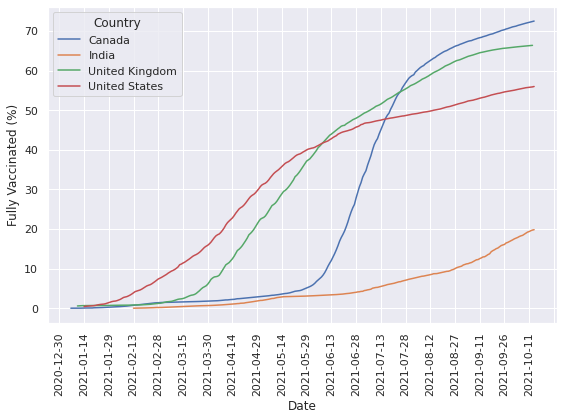

In [ ]:
# Check the original trend of the dataset; select 4 countries vaccination trend for example
df_4_process = df_process_cleaning.loc[(df_process_cleaning['country'] == 
                                        'United States') | (df_process_cleaning['country'] == 'India') |
                                                            (df_process_cleaning['country'] == 'Canada') |
                                       (df_process_cleaning['country'] == 'United Kingdom')][['date', 'country', 'people_fully_vaccinated_per_hundred']]
df_4_process = df_4_process.rename(columns = {'people_fully_vaccinated_per_hundred': 'Fully Vaccinated (%)', 'country': 'Country',
                        'date': 'Date'})
sns.reset_orig()
plt.figure(figsize=(8,6))
sns.set_theme(style = "darkgrid")
ax = sns.lineplot(data = df_4_process, x = 'Date', y = 'Fully Vaccinated (%)', hue = 'Country')
ax.xaxis.set_major_locator(mdates.DayLocator(interval= 15))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Percentage of Fully Vaccinated by Countries.jpeg', dpi = 300)
plt.show();